In [6]:
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (precision_recall_curve, average_precision_score, 
                            f1_score, confusion_matrix, classification_report)
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump

# Set random seed for reproducibility
np.random.seed(42)


In [7]:
# 1. Load Preprocessed Data (from Task 1) 
fraud_X_train = pd.read_csv('../Data/processed/fraud_X_train.csv')
fraud_X_test = pd.read_csv('../Data/processed/fraud_X_test.csv')
fraud_y_train = pd.read_csv('../Data/processed/fraud_y_train.csv').squeeze()
fraud_y_test = pd.read_csv('../Data/processed/fraud_y_test.csv').squeeze()

cc_X_train = pd.read_csv('../Data/processed/creditcard_X_train.csv')
cc_X_test = pd.read_csv('../Data/processed/creditcard_X_test.csv')
cc_y_train = pd.read_csv('../Data/processed/creditcard_y_train.csv').squeeze()
cc_y_test = pd.read_csv('../Data/processed/creditcard_y_test.csv').squeeze()


In [10]:
from sklearn.metrics import log_loss

def optimize_xgb(X, y, n_trials=50, n_splits=2):
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 8),
            'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),
            'subsample': trial.suggest_float('subsample', 0.7, 0.9),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
            'gamma': trial.suggest_float('gamma', 0, 2),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
            'scale_pos_weight': len(y[y==0])/len(y[y==1]),
            'eval_metric': 'logloss',
            'random_state': 42,
            'n_jobs': -1
        }
        
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        val_scores = []
        
        for train_idx, val_idx in cv.split(X, y):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            model = XGBClassifier(**params).fit(X_train, y_train)
            y_proba = model.predict_proba(X_val)
            val_scores.append(log_loss(y_val, y_proba))
            
        return np.mean(val_scores)
    
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    print(f"\nBest trial for {X.shape[0]} samples:")
    trial = study.best_trial
    print(f"Log Loss: {trial.value:.4f}")
    print("Best params:")
    for key, value in trial.params.items():
        print(f"{key}: {value}")
    
    return study.best_params

# Run optimization
print("Optimizing XGBoost for Fraud Data...")
best_params_fraud = optimize_xgb(fraud_X_train, fraud_y_train)
print("\nOptimizing XGBoost for Credit Card Data...")
best_params_cc = optimize_xgb(cc_X_train, cc_y_train)

[I 2025-07-20 14:39:01,580] A new study created in memory with name: no-name-16b05a83-5ab3-4256-a0b1-a06baddc49b1


Optimizing XGBoost for Fraud Data...


Best trial: 0. Best value: 0.108201:   2%|▏         | 1/50 [00:21<17:21, 21.25s/it]

[I 2025-07-20 14:39:22,833] Trial 0 finished with value: 0.1082005589449185 and parameters: {'n_estimators': 297, 'max_depth': 7, 'learning_rate': 0.05022447687520283, 'subsample': 0.7691325466394949, 'colsample_bytree': 0.7377034355846002, 'gamma': 1.2114485513568019, 'min_child_weight': 3}. Best is trial 0 with value: 0.1082005589449185.


Best trial: 1. Best value: 0.106339:   4%|▍         | 2/50 [00:34<13:28, 16.84s/it]

[I 2025-07-20 14:39:36,573] Trial 1 finished with value: 0.10633926216467779 and parameters: {'n_estimators': 155, 'max_depth': 7, 'learning_rate': 0.11263714610855927, 'subsample': 0.8828857064760309, 'colsample_bytree': 0.7534070233716903, 'gamma': 0.096928666800145, 'min_child_weight': 3}. Best is trial 1 with value: 0.10633926216467779.


Best trial: 2. Best value: 0.102873:   6%|▌         | 3/50 [00:55<14:29, 18.50s/it]

[I 2025-07-20 14:39:57,061] Trial 2 finished with value: 0.102872768979513 and parameters: {'n_estimators': 263, 'max_depth': 6, 'learning_rate': 0.09936398555364373, 'subsample': 0.8184217388801746, 'colsample_bytree': 0.829630394907706, 'gamma': 1.2328090873012267, 'min_child_weight': 1}. Best is trial 2 with value: 0.102872768979513.


Best trial: 2. Best value: 0.102873:   8%|▊         | 4/50 [01:03<11:04, 14.46s/it]

[I 2025-07-20 14:40:05,312] Trial 3 finished with value: 0.1229689259772565 and parameters: {'n_estimators': 143, 'max_depth': 3, 'learning_rate': 0.14703887692359305, 'subsample': 0.7560862118005722, 'colsample_bytree': 0.7531539880342601, 'gamma': 1.9546702388255195, 'min_child_weight': 1}. Best is trial 2 with value: 0.102872768979513.


Best trial: 2. Best value: 0.102873:  10%|█         | 5/50 [01:20<11:33, 15.41s/it]

[I 2025-07-20 14:40:22,403] Trial 4 finished with value: 0.10724870062156944 and parameters: {'n_estimators': 291, 'max_depth': 7, 'learning_rate': 0.054288561576024436, 'subsample': 0.8529143092510443, 'colsample_bytree': 0.7382717456913888, 'gamma': 0.01597099561994164, 'min_child_weight': 3}. Best is trial 2 with value: 0.102872768979513.


Best trial: 5. Best value: 0.100933:  12%|█▏        | 6/50 [01:32<10:23, 14.18s/it]

[I 2025-07-20 14:40:34,194] Trial 5 finished with value: 0.10093322474677663 and parameters: {'n_estimators': 161, 'max_depth': 8, 'learning_rate': 0.1860572412604924, 'subsample': 0.8087417864343956, 'colsample_bytree': 0.8765182373070661, 'gamma': 0.033344248298683876, 'min_child_weight': 2}. Best is trial 5 with value: 0.10093322474677663.


Best trial: 5. Best value: 0.100933:  14%|█▍        | 7/50 [01:45<09:44, 13.60s/it]

[I 2025-07-20 14:40:46,620] Trial 6 finished with value: 0.10857138327983579 and parameters: {'n_estimators': 215, 'max_depth': 5, 'learning_rate': 0.09842995570686014, 'subsample': 0.8103836883443292, 'colsample_bytree': 0.8814966538032973, 'gamma': 0.5418709521730576, 'min_child_weight': 3}. Best is trial 5 with value: 0.10093322474677663.


Best trial: 5. Best value: 0.100933:  16%|█▌        | 8/50 [02:00<09:49, 14.05s/it]

[I 2025-07-20 14:41:01,612] Trial 7 finished with value: 0.10285687850731204 and parameters: {'n_estimators': 231, 'max_depth': 8, 'learning_rate': 0.08693484253486441, 'subsample': 0.8891558172733258, 'colsample_bytree': 0.8366406576557355, 'gamma': 0.301329384312621, 'min_child_weight': 3}. Best is trial 5 with value: 0.10093322474677663.


Best trial: 5. Best value: 0.100933:  18%|█▊        | 9/50 [02:16<10:03, 14.72s/it]

[I 2025-07-20 14:41:17,827] Trial 8 finished with value: 0.10414808961293705 and parameters: {'n_estimators': 279, 'max_depth': 7, 'learning_rate': 0.06969151704154239, 'subsample': 0.8438172956822809, 'colsample_bytree': 0.8109260484873341, 'gamma': 1.6484106884503835, 'min_child_weight': 2}. Best is trial 5 with value: 0.10093322474677663.


Best trial: 5. Best value: 0.100933:  20%|██        | 10/50 [02:33<10:26, 15.66s/it]

[I 2025-07-20 14:41:35,578] Trial 9 finished with value: 0.10275129457246739 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.19110172753654042, 'subsample': 0.775729467398122, 'colsample_bytree': 0.7939337283743887, 'gamma': 1.9124867351086074, 'min_child_weight': 5}. Best is trial 5 with value: 0.10093322474677663.


Best trial: 5. Best value: 0.100933:  22%|██▏       | 11/50 [02:42<08:46, 13.50s/it]

[I 2025-07-20 14:41:44,174] Trial 10 finished with value: 0.1143189248798841 and parameters: {'n_estimators': 105, 'max_depth': 4, 'learning_rate': 0.1883183483832277, 'subsample': 0.7088286114488028, 'colsample_bytree': 0.8976446588129201, 'gamma': 0.7274070251651712, 'min_child_weight': 5}. Best is trial 5 with value: 0.10093322474677663.


Best trial: 5. Best value: 0.100933:  24%|██▍       | 12/50 [02:56<08:34, 13.53s/it]

[I 2025-07-20 14:41:57,781] Trial 11 finished with value: 0.10308410645995633 and parameters: {'n_estimators': 175, 'max_depth': 8, 'learning_rate': 0.1997699794361876, 'subsample': 0.764067854260057, 'colsample_bytree': 0.7819926284282769, 'gamma': 1.583988317276479, 'min_child_weight': 5}. Best is trial 5 with value: 0.10093322474677663.


Best trial: 5. Best value: 0.100933:  26%|██▌       | 13/50 [03:10<08:31, 13.84s/it]

[I 2025-07-20 14:42:12,321] Trial 12 finished with value: 0.10244372852073126 and parameters: {'n_estimators': 186, 'max_depth': 8, 'learning_rate': 0.16082172884931217, 'subsample': 0.7885204434467725, 'colsample_bytree': 0.7044662964735111, 'gamma': 0.8789110444916767, 'min_child_weight': 4}. Best is trial 5 with value: 0.10093322474677663.


Best trial: 5. Best value: 0.100933:  28%|██▊       | 14/50 [03:22<07:58, 13.30s/it]

[I 2025-07-20 14:42:24,369] Trial 13 finished with value: 0.105277697536239 and parameters: {'n_estimators': 172, 'max_depth': 6, 'learning_rate': 0.15606978895758086, 'subsample': 0.7356354946108338, 'colsample_bytree': 0.7035921206039839, 'gamma': 0.8444715115129735, 'min_child_weight': 4}. Best is trial 5 with value: 0.10093322474677663.


Best trial: 5. Best value: 0.100933:  30%|███       | 15/50 [03:32<07:12, 12.36s/it]

[I 2025-07-20 14:42:34,551] Trial 14 finished with value: 0.10274477504711291 and parameters: {'n_estimators': 119, 'max_depth': 8, 'learning_rate': 0.16507329702904025, 'subsample': 0.7958859577202537, 'colsample_bytree': 0.8683110352630266, 'gamma': 0.39927273337611996, 'min_child_weight': 2}. Best is trial 5 with value: 0.10093322474677663.


Best trial: 5. Best value: 0.100933:  32%|███▏      | 16/50 [03:44<06:52, 12.14s/it]

[I 2025-07-20 14:42:46,199] Trial 15 finished with value: 0.10822747196924085 and parameters: {'n_estimators': 183, 'max_depth': 5, 'learning_rate': 0.13581470321353578, 'subsample': 0.8370607240752577, 'colsample_bytree': 0.7065636805186695, 'gamma': 1.0941867030594183, 'min_child_weight': 4}. Best is trial 5 with value: 0.10093322474677663.


Best trial: 5. Best value: 0.100933:  34%|███▍      | 17/50 [04:00<07:20, 13.34s/it]

[I 2025-07-20 14:43:02,322] Trial 16 finished with value: 0.10113529428205448 and parameters: {'n_estimators': 237, 'max_depth': 6, 'learning_rate': 0.1755765654261435, 'subsample': 0.7956309390819473, 'colsample_bytree': 0.8569966079513855, 'gamma': 0.6643238776458721, 'min_child_weight': 2}. Best is trial 5 with value: 0.10093322474677663.


Best trial: 5. Best value: 0.100933:  36%|███▌      | 18/50 [04:13<07:05, 13.31s/it]

[I 2025-07-20 14:43:15,561] Trial 17 finished with value: 0.10374857206723483 and parameters: {'n_estimators': 244, 'max_depth': 4, 'learning_rate': 0.17480077601493194, 'subsample': 0.8233023125935202, 'colsample_bytree': 0.8551144761937791, 'gamma': 0.5835434562951205, 'min_child_weight': 1}. Best is trial 5 with value: 0.10093322474677663.


Best trial: 5. Best value: 0.100933:  38%|███▊      | 19/50 [04:28<06:59, 13.55s/it]

[I 2025-07-20 14:43:29,664] Trial 18 finished with value: 0.10115796360604343 and parameters: {'n_estimators': 220, 'max_depth': 6, 'learning_rate': 0.17737686942415426, 'subsample': 0.8604025075039046, 'colsample_bytree': 0.849248982702396, 'gamma': 0.28255706198620456, 'min_child_weight': 2}. Best is trial 5 with value: 0.10093322474677663.


Best trial: 5. Best value: 0.100933:  40%|████      | 20/50 [04:42<06:51, 13.72s/it]

[I 2025-07-20 14:43:43,776] Trial 19 finished with value: 0.103664293969526 and parameters: {'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.1307480455100614, 'subsample': 0.7398288438547497, 'colsample_bytree': 0.8991636962856837, 'gamma': 0.10865701324256416, 'min_child_weight': 2}. Best is trial 5 with value: 0.10093322474677663.


Best trial: 5. Best value: 0.100933:  42%|████▏     | 21/50 [04:50<05:50, 12.08s/it]

[I 2025-07-20 14:43:52,050] Trial 20 finished with value: 0.12272768084278682 and parameters: {'n_estimators': 136, 'max_depth': 3, 'learning_rate': 0.14644009982988324, 'subsample': 0.7962141727532968, 'colsample_bytree': 0.8183628034929694, 'gamma': 0.5537082280802229, 'min_child_weight': 2}. Best is trial 5 with value: 0.10093322474677663.


Best trial: 5. Best value: 0.100933:  44%|████▍     | 22/50 [05:04<05:56, 12.72s/it]

[I 2025-07-20 14:44:06,237] Trial 21 finished with value: 0.10126011443844185 and parameters: {'n_estimators': 218, 'max_depth': 6, 'learning_rate': 0.1751341728151679, 'subsample': 0.8641075523317513, 'colsample_bytree': 0.8519942109666719, 'gamma': 0.2883734867290945, 'min_child_weight': 2}. Best is trial 5 with value: 0.10093322474677663.


Best trial: 5. Best value: 0.100933:  46%|████▌     | 23/50 [05:30<07:26, 16.55s/it]

[I 2025-07-20 14:44:31,740] Trial 22 finished with value: 0.10133219260903115 and parameters: {'n_estimators': 205, 'max_depth': 6, 'learning_rate': 0.17720205771664474, 'subsample': 0.8704729871869077, 'colsample_bytree': 0.8732582599779961, 'gamma': 0.23351145807031845, 'min_child_weight': 2}. Best is trial 5 with value: 0.10093322474677663.


Best trial: 5. Best value: 0.100933:  48%|████▊     | 24/50 [05:53<08:05, 18.68s/it]

[I 2025-07-20 14:44:55,388] Trial 23 finished with value: 0.10382140822336125 and parameters: {'n_estimators': 231, 'max_depth': 4, 'learning_rate': 0.1836538356781674, 'subsample': 0.8306875663456401, 'colsample_bytree': 0.8504749503335912, 'gamma': 0.39983620093623035, 'min_child_weight': 1}. Best is trial 5 with value: 0.10093322474677663.


Best trial: 24. Best value: 0.100799:  50%|█████     | 25/50 [06:18<08:33, 20.53s/it]

[I 2025-07-20 14:45:20,221] Trial 24 finished with value: 0.10079868824088015 and parameters: {'n_estimators': 251, 'max_depth': 7, 'learning_rate': 0.19985963172664126, 'subsample': 0.8528301161501634, 'colsample_bytree': 0.8793291851181717, 'gamma': 0.7367898407295707, 'min_child_weight': 2}. Best is trial 24 with value: 0.10079868824088015.


Best trial: 25. Best value: 0.100602:  52%|█████▏    | 26/50 [06:43<08:41, 21.71s/it]

[I 2025-07-20 14:45:44,643] Trial 25 finished with value: 0.10060237018839877 and parameters: {'n_estimators': 270, 'max_depth': 7, 'learning_rate': 0.19433956291840476, 'subsample': 0.8125171130157327, 'colsample_bytree': 0.8891398181546437, 'gamma': 0.7120567866557281, 'min_child_weight': 1}. Best is trial 25 with value: 0.10060237018839877.


Best trial: 26. Best value: 0.100439:  54%|█████▍    | 27/50 [07:15<09:35, 25.04s/it]

[I 2025-07-20 14:46:17,498] Trial 26 finished with value: 0.10043949832058346 and parameters: {'n_estimators': 266, 'max_depth': 7, 'learning_rate': 0.19841926000446028, 'subsample': 0.8133360123185263, 'colsample_bytree': 0.8842948559499012, 'gamma': 0.9419856030419591, 'min_child_weight': 1}. Best is trial 26 with value: 0.10043949832058346.


Best trial: 27. Best value: 0.100136:  56%|█████▌    | 28/50 [07:49<10:09, 27.72s/it]

[I 2025-07-20 14:46:51,469] Trial 27 finished with value: 0.10013560274436513 and parameters: {'n_estimators': 263, 'max_depth': 7, 'learning_rate': 0.19888964426473718, 'subsample': 0.8458897790139571, 'colsample_bytree': 0.889042812809422, 'gamma': 1.0240205390758077, 'min_child_weight': 1}. Best is trial 27 with value: 0.10013560274436513.


Best trial: 27. Best value: 0.100136:  58%|█████▊    | 29/50 [08:20<09:59, 28.56s/it]

[I 2025-07-20 14:47:22,000] Trial 28 finished with value: 0.10063125055632155 and parameters: {'n_estimators': 270, 'max_depth': 7, 'learning_rate': 0.19565056086988844, 'subsample': 0.840128086630713, 'colsample_bytree': 0.8897336012212534, 'gamma': 1.0186341837167112, 'min_child_weight': 1}. Best is trial 27 with value: 0.10013560274436513.


Best trial: 29. Best value: 0.0998422:  60%|██████    | 30/50 [08:53<09:59, 29.98s/it]

[I 2025-07-20 14:47:55,285] Trial 29 finished with value: 0.09984216349406055 and parameters: {'n_estimators': 287, 'max_depth': 7, 'learning_rate': 0.16545809071857667, 'subsample': 0.7771619197350546, 'colsample_bytree': 0.8654174833443185, 'gamma': 1.2368530136793336, 'min_child_weight': 1}. Best is trial 29 with value: 0.09984216349406055.


Best trial: 29. Best value: 0.0998422:  62%|██████▏   | 31/50 [09:25<09:41, 30.58s/it]

[I 2025-07-20 14:48:27,286] Trial 30 finished with value: 0.0999051619994142 and parameters: {'n_estimators': 298, 'max_depth': 7, 'learning_rate': 0.16575299029454746, 'subsample': 0.7784811767017138, 'colsample_bytree': 0.8704287385694806, 'gamma': 1.3225036790678348, 'min_child_weight': 1}. Best is trial 29 with value: 0.09984216349406055.


Best trial: 29. Best value: 0.0998422:  64%|██████▍   | 32/50 [09:48<08:26, 28.11s/it]

[I 2025-07-20 14:48:49,636] Trial 31 finished with value: 0.09997762390180642 and parameters: {'n_estimators': 295, 'max_depth': 7, 'learning_rate': 0.1658242713571106, 'subsample': 0.780688779847422, 'colsample_bytree': 0.8667041033685788, 'gamma': 1.3210599871052637, 'min_child_weight': 1}. Best is trial 29 with value: 0.09984216349406055.


Best trial: 32. Best value: 0.0996932:  66%|██████▌   | 33/50 [10:10<07:27, 26.30s/it]

[I 2025-07-20 14:49:11,704] Trial 32 finished with value: 0.09969321265384903 and parameters: {'n_estimators': 297, 'max_depth': 7, 'learning_rate': 0.14826609720024106, 'subsample': 0.7783470823136606, 'colsample_bytree': 0.8638497257461377, 'gamma': 1.3284811748072292, 'min_child_weight': 1}. Best is trial 32 with value: 0.09969321265384903.


Best trial: 32. Best value: 0.0996932:  68%|██████▊   | 34/50 [10:29<06:28, 24.26s/it]

[I 2025-07-20 14:49:31,207] Trial 33 finished with value: 0.0999484064211014 and parameters: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.11774637623147718, 'subsample': 0.7761502639633557, 'colsample_bytree': 0.8346142854234911, 'gamma': 1.3499382410936098, 'min_child_weight': 1}. Best is trial 32 with value: 0.09969321265384903.


Best trial: 32. Best value: 0.0996932:  70%|███████   | 35/50 [10:47<05:34, 22.28s/it]

[I 2025-07-20 14:49:48,864] Trial 34 finished with value: 0.10114656037847466 and parameters: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.1171085308149936, 'subsample': 0.7480096158351885, 'colsample_bytree': 0.8294936798835709, 'gamma': 1.4078098054911032, 'min_child_weight': 1}. Best is trial 32 with value: 0.09969321265384903.


Best trial: 32. Best value: 0.0996932:  72%|███████▏  | 36/50 [11:04<04:52, 20.87s/it]

[I 2025-07-20 14:50:06,442] Trial 35 finished with value: 0.09984779274197689 and parameters: {'n_estimators': 284, 'max_depth': 7, 'learning_rate': 0.1444203348349568, 'subsample': 0.7637010267330903, 'colsample_bytree': 0.8373793377413256, 'gamma': 1.4177134013608899, 'min_child_weight': 1}. Best is trial 32 with value: 0.09969321265384903.


Best trial: 36. Best value: 0.0995805:  74%|███████▍  | 37/50 [11:24<04:26, 20.47s/it]

[I 2025-07-20 14:50:25,983] Trial 36 finished with value: 0.09958047432134978 and parameters: {'n_estimators': 278, 'max_depth': 8, 'learning_rate': 0.14875864794086502, 'subsample': 0.7224814099853881, 'colsample_bytree': 0.8413137344017177, 'gamma': 1.5185648779497358, 'min_child_weight': 1}. Best is trial 36 with value: 0.09958047432134978.


Best trial: 36. Best value: 0.0995805:  76%|███████▌  | 38/50 [11:41<03:54, 19.53s/it]

[I 2025-07-20 14:50:43,327] Trial 37 finished with value: 0.0996085448986532 and parameters: {'n_estimators': 283, 'max_depth': 8, 'learning_rate': 0.14270396337652305, 'subsample': 0.7174984049003056, 'colsample_bytree': 0.8200924606510092, 'gamma': 1.5366884597054153, 'min_child_weight': 1}. Best is trial 36 with value: 0.09958047432134978.


Best trial: 36. Best value: 0.0995805:  78%|███████▊  | 39/50 [11:59<03:28, 18.97s/it]

[I 2025-07-20 14:51:00,988] Trial 38 finished with value: 0.09973439255341587 and parameters: {'n_estimators': 283, 'max_depth': 8, 'learning_rate': 0.13782880461974897, 'subsample': 0.7074035171523543, 'colsample_bytree': 0.7793622869538017, 'gamma': 1.5832561684693685, 'min_child_weight': 1}. Best is trial 36 with value: 0.09958047432134978.


Best trial: 36. Best value: 0.0995805:  80%|████████  | 40/50 [12:16<03:04, 18.45s/it]

[I 2025-07-20 14:51:18,220] Trial 39 finished with value: 0.10127085039287097 and parameters: {'n_estimators': 277, 'max_depth': 8, 'learning_rate': 0.13550333615967589, 'subsample': 0.7004300268637513, 'colsample_bytree': 0.7695463840871316, 'gamma': 1.7269686260961246, 'min_child_weight': 3}. Best is trial 36 with value: 0.09958047432134978.


Best trial: 36. Best value: 0.0995805:  82%|████████▏ | 41/50 [12:33<02:41, 17.90s/it]

[I 2025-07-20 14:51:34,834] Trial 40 finished with value: 0.10069301793880688 and parameters: {'n_estimators': 256, 'max_depth': 8, 'learning_rate': 0.10306508098044834, 'subsample': 0.7208114794359254, 'colsample_bytree': 0.8010477437734171, 'gamma': 1.792904718618367, 'min_child_weight': 1}. Best is trial 36 with value: 0.09958047432134978.


Best trial: 36. Best value: 0.0995805:  84%|████████▍ | 42/50 [12:52<02:26, 18.34s/it]

[I 2025-07-20 14:51:54,206] Trial 41 finished with value: 0.09969734644264029 and parameters: {'n_estimators': 288, 'max_depth': 8, 'learning_rate': 0.15462436522542278, 'subsample': 0.7240676562844043, 'colsample_bytree': 0.8199662186705285, 'gamma': 1.5148151971443737, 'min_child_weight': 1}. Best is trial 36 with value: 0.09958047432134978.


Best trial: 36. Best value: 0.0995805:  86%|████████▌ | 43/50 [13:10<02:06, 18.07s/it]

[I 2025-07-20 14:52:11,639] Trial 42 finished with value: 0.09967007088968505 and parameters: {'n_estimators': 277, 'max_depth': 8, 'learning_rate': 0.15237962574541095, 'subsample': 0.723513291271026, 'colsample_bytree': 0.8184940585460387, 'gamma': 1.5663840333890353, 'min_child_weight': 1}. Best is trial 36 with value: 0.09958047432134978.


Best trial: 36. Best value: 0.0995805:  88%|████████▊ | 44/50 [13:27<01:47, 17.92s/it]

[I 2025-07-20 14:52:29,229] Trial 43 finished with value: 0.09992892654335941 and parameters: {'n_estimators': 277, 'max_depth': 8, 'learning_rate': 0.12728249771629288, 'subsample': 0.7250943861563734, 'colsample_bytree': 0.8175015166538298, 'gamma': 1.53369223595184, 'min_child_weight': 1}. Best is trial 36 with value: 0.09958047432134978.


Best trial: 36. Best value: 0.0995805:  90%|█████████ | 45/50 [13:43<01:26, 17.24s/it]

[I 2025-07-20 14:52:44,875] Trial 44 finished with value: 0.10013583340199185 and parameters: {'n_estimators': 260, 'max_depth': 8, 'learning_rate': 0.1513048982131088, 'subsample': 0.7214242620374042, 'colsample_bytree': 0.8027769524903504, 'gamma': 1.8506548366685536, 'min_child_weight': 1}. Best is trial 36 with value: 0.09958047432134978.


Best trial: 36. Best value: 0.0995805:  92%|█████████▏| 46/50 [14:00<01:09, 17.31s/it]

[I 2025-07-20 14:53:02,341] Trial 45 finished with value: 0.0998911560273572 and parameters: {'n_estimators': 289, 'max_depth': 8, 'learning_rate': 0.15448248401945627, 'subsample': 0.7348579808992602, 'colsample_bytree': 0.8212447233480781, 'gamma': 1.691413852027502, 'min_child_weight': 1}. Best is trial 36 with value: 0.09958047432134978.


Best trial: 36. Best value: 0.0995805:  94%|█████████▍| 47/50 [14:17<00:51, 17.25s/it]

[I 2025-07-20 14:53:19,443] Trial 46 finished with value: 0.10046518207522952 and parameters: {'n_estimators': 275, 'max_depth': 8, 'learning_rate': 0.14304249297705646, 'subsample': 0.7544033240158947, 'colsample_bytree': 0.8431078726501036, 'gamma': 1.5431533636799293, 'min_child_weight': 2}. Best is trial 36 with value: 0.09958047432134978.


Best trial: 36. Best value: 0.0995805:  96%|█████████▌| 48/50 [14:34<00:34, 17.10s/it]

[I 2025-07-20 14:53:36,214] Trial 47 finished with value: 0.10005942262600803 and parameters: {'n_estimators': 290, 'max_depth': 8, 'learning_rate': 0.15458266654849376, 'subsample': 0.7151673478325513, 'colsample_bytree': 0.8105166830746826, 'gamma': 1.99921223117669, 'min_child_weight': 1}. Best is trial 36 with value: 0.09958047432134978.


Best trial: 36. Best value: 0.0995805:  98%|█████████▊| 49/50 [14:53<00:17, 17.48s/it]

[I 2025-07-20 14:53:54,583] Trial 48 finished with value: 0.10021426104338757 and parameters: {'n_estimators': 283, 'max_depth': 8, 'learning_rate': 0.12303887574257821, 'subsample': 0.7301856186883651, 'colsample_bytree': 0.8260975593913782, 'gamma': 1.1557307237444245, 'min_child_weight': 2}. Best is trial 36 with value: 0.09958047432134978.


Best trial: 36. Best value: 0.0995805: 100%|██████████| 50/50 [15:09<00:00, 18.20s/it]
[I 2025-07-20 14:54:11,463] A new study created in memory with name: no-name-81e7208a-1455-4cbf-b12d-5b3bccc321bc


[I 2025-07-20 14:54:11,452] Trial 49 finished with value: 0.0998373857951681 and parameters: {'n_estimators': 271, 'max_depth': 8, 'learning_rate': 0.15951701347161992, 'subsample': 0.7469431575446795, 'colsample_bytree': 0.7853314907167392, 'gamma': 1.6454242025004564, 'min_child_weight': 1}. Best is trial 36 with value: 0.09958047432134978.

Best trial for 219136 samples:
Log Loss: 0.0996
Best params:
n_estimators: 278
max_depth: 8
learning_rate: 0.14875864794086502
subsample: 0.7224814099853881
colsample_bytree: 0.8413137344017177
gamma: 1.5185648779497358
min_child_weight: 1

Optimizing XGBoost for Credit Card Data...


Best trial: 0. Best value: 0.180578:   2%|▏         | 1/50 [00:00<00:17,  2.75it/s]

[I 2025-07-20 14:54:11,824] Trial 0 finished with value: 0.18057761549642637 and parameters: {'n_estimators': 198, 'max_depth': 5, 'learning_rate': 0.12343921790887548, 'subsample': 0.7825741003285913, 'colsample_bytree': 0.7873055357170975, 'gamma': 0.9723497904280103, 'min_child_weight': 2}. Best is trial 0 with value: 0.18057761549642637.


Best trial: 0. Best value: 0.180578:   4%|▍         | 2/50 [00:00<00:18,  2.54it/s]

[I 2025-07-20 14:54:12,238] Trial 1 finished with value: 0.19523575006991223 and parameters: {'n_estimators': 247, 'max_depth': 6, 'learning_rate': 0.09461009778102489, 'subsample': 0.7282337205241476, 'colsample_bytree': 0.7397984330272416, 'gamma': 0.4898169082396997, 'min_child_weight': 2}. Best is trial 0 with value: 0.18057761549642637.


Best trial: 0. Best value: 0.180578:   6%|▌         | 3/50 [00:01<00:20,  2.32it/s]

[I 2025-07-20 14:54:12,715] Trial 2 finished with value: 0.1855599742979986 and parameters: {'n_estimators': 209, 'max_depth': 7, 'learning_rate': 0.16002330778493135, 'subsample': 0.8667841730074358, 'colsample_bytree': 0.8452269275212395, 'gamma': 1.1103374069574132, 'min_child_weight': 5}. Best is trial 0 with value: 0.18057761549642637.


Best trial: 3. Best value: 0.17794:   8%|▊         | 4/50 [00:01<00:19,  2.42it/s] 

[I 2025-07-20 14:54:13,102] Trial 3 finished with value: 0.1779402411707194 and parameters: {'n_estimators': 240, 'max_depth': 4, 'learning_rate': 0.06759685007470127, 'subsample': 0.8993295771569707, 'colsample_bytree': 0.8053106074819438, 'gamma': 1.2429161418294303, 'min_child_weight': 4}. Best is trial 3 with value: 0.1779402411707194.


Best trial: 3. Best value: 0.17794:  10%|█         | 5/50 [00:02<00:18,  2.46it/s]

[I 2025-07-20 14:54:13,493] Trial 4 finished with value: 0.18247853346165013 and parameters: {'n_estimators': 204, 'max_depth': 7, 'learning_rate': 0.06778955645268651, 'subsample': 0.7267443120581778, 'colsample_bytree': 0.7697173661216147, 'gamma': 1.3812813724230206, 'min_child_weight': 2}. Best is trial 3 with value: 0.1779402411707194.


Best trial: 3. Best value: 0.17794:  12%|█▏        | 6/50 [00:02<00:16,  2.62it/s]

[I 2025-07-20 14:54:13,827] Trial 5 finished with value: 0.17949621912684077 and parameters: {'n_estimators': 130, 'max_depth': 5, 'learning_rate': 0.12410760102464272, 'subsample': 0.7769282946775814, 'colsample_bytree': 0.7464286859703653, 'gamma': 1.614091869982916, 'min_child_weight': 2}. Best is trial 3 with value: 0.1779402411707194.


Best trial: 3. Best value: 0.17794:  14%|█▍        | 7/50 [00:02<00:16,  2.59it/s]

[I 2025-07-20 14:54:14,224] Trial 6 finished with value: 0.19100938292320252 and parameters: {'n_estimators': 236, 'max_depth': 7, 'learning_rate': 0.16484289279269831, 'subsample': 0.7956879017022612, 'colsample_bytree': 0.8804192649781841, 'gamma': 1.5436881626077819, 'min_child_weight': 4}. Best is trial 3 with value: 0.1779402411707194.


Best trial: 7. Best value: 0.177323:  16%|█▌        | 8/50 [00:03<00:14,  2.82it/s]

[I 2025-07-20 14:54:14,503] Trial 7 finished with value: 0.17732282581426795 and parameters: {'n_estimators': 142, 'max_depth': 5, 'learning_rate': 0.10568588415549773, 'subsample': 0.8271033299286801, 'colsample_bytree': 0.8003496082211421, 'gamma': 1.4413404083870132, 'min_child_weight': 4}. Best is trial 7 with value: 0.17732282581426795.


Best trial: 7. Best value: 0.177323:  18%|█▊        | 9/50 [00:03<00:14,  2.80it/s]

[I 2025-07-20 14:54:14,871] Trial 8 finished with value: 0.17870630820320618 and parameters: {'n_estimators': 127, 'max_depth': 4, 'learning_rate': 0.05770183752057497, 'subsample': 0.7068759568261176, 'colsample_bytree': 0.7356895356036757, 'gamma': 0.4006288404741074, 'min_child_weight': 2}. Best is trial 7 with value: 0.17732282581426795.


Best trial: 7. Best value: 0.177323:  20%|██        | 10/50 [00:03<00:14,  2.74it/s]

[I 2025-07-20 14:54:15,253] Trial 9 finished with value: 0.18694877428660384 and parameters: {'n_estimators': 228, 'max_depth': 5, 'learning_rate': 0.1030315910014287, 'subsample': 0.7162104785761079, 'colsample_bytree': 0.7874881616359032, 'gamma': 1.7683708312129651, 'min_child_weight': 3}. Best is trial 7 with value: 0.17732282581426795.


Best trial: 7. Best value: 0.177323:  22%|██▏       | 11/50 [00:04<00:14,  2.64it/s]

[I 2025-07-20 14:54:15,666] Trial 10 finished with value: 0.19390743574131325 and parameters: {'n_estimators': 160, 'max_depth': 3, 'learning_rate': 0.1919130468444866, 'subsample': 0.8446008679177853, 'colsample_bytree': 0.7040300590465489, 'gamma': 0.0013131166771362945, 'min_child_weight': 5}. Best is trial 7 with value: 0.17732282581426795.


Best trial: 7. Best value: 0.177323:  24%|██▍       | 12/50 [00:04<00:17,  2.21it/s]

[I 2025-07-20 14:54:16,288] Trial 11 finished with value: 0.18128149967700777 and parameters: {'n_estimators': 286, 'max_depth': 3, 'learning_rate': 0.08117177980595905, 'subsample': 0.8966213125756356, 'colsample_bytree': 0.8318919502484879, 'gamma': 1.1328916560574718, 'min_child_weight': 4}. Best is trial 7 with value: 0.17732282581426795.


Best trial: 12. Best value: 0.174262:  26%|██▌       | 13/50 [00:05<00:17,  2.14it/s]

[I 2025-07-20 14:54:16,781] Trial 12 finished with value: 0.1742620931932849 and parameters: {'n_estimators': 162, 'max_depth': 4, 'learning_rate': 0.10069743991791343, 'subsample': 0.8479130680379372, 'colsample_bytree': 0.8268398882505578, 'gamma': 1.9477409374232921, 'min_child_weight': 4}. Best is trial 12 with value: 0.1742620931932849.


Best trial: 13. Best value: 0.173565:  28%|██▊       | 14/50 [00:05<00:18,  1.98it/s]

[I 2025-07-20 14:54:17,380] Trial 13 finished with value: 0.17356463622547486 and parameters: {'n_estimators': 164, 'max_depth': 4, 'learning_rate': 0.10273289120210749, 'subsample': 0.8286589761930826, 'colsample_bytree': 0.8373900573486305, 'gamma': 1.9521682821800772, 'min_child_weight': 3}. Best is trial 13 with value: 0.17356463622547486.


Best trial: 13. Best value: 0.173565:  30%|███       | 15/50 [00:06<00:18,  1.86it/s]

[I 2025-07-20 14:54:17,986] Trial 14 finished with value: 0.17429465227953145 and parameters: {'n_estimators': 101, 'max_depth': 4, 'learning_rate': 0.1458531327592027, 'subsample': 0.826017817797448, 'colsample_bytree': 0.8701223035030099, 'gamma': 1.9407329076945012, 'min_child_weight': 3}. Best is trial 13 with value: 0.17356463622547486.


Best trial: 15. Best value: 0.168356:  32%|███▏      | 16/50 [00:07<00:20,  1.65it/s]

[I 2025-07-20 14:54:18,755] Trial 15 finished with value: 0.16835566923583895 and parameters: {'n_estimators': 176, 'max_depth': 3, 'learning_rate': 0.0925563852133119, 'subsample': 0.8617860073776922, 'colsample_bytree': 0.8412397427133376, 'gamma': 1.9853366898132965, 'min_child_weight': 1}. Best is trial 15 with value: 0.16835566923583895.


Best trial: 15. Best value: 0.168356:  34%|███▍      | 17/50 [00:07<00:18,  1.79it/s]

[I 2025-07-20 14:54:19,211] Trial 16 finished with value: 0.18264538742368194 and parameters: {'n_estimators': 178, 'max_depth': 3, 'learning_rate': 0.0823885674569826, 'subsample': 0.7556834417555879, 'colsample_bytree': 0.8574678255246881, 'gamma': 0.8085654023702937, 'min_child_weight': 1}. Best is trial 15 with value: 0.16835566923583895.


Best trial: 15. Best value: 0.168356:  36%|███▌      | 18/50 [00:08<00:16,  1.96it/s]

[I 2025-07-20 14:54:19,598] Trial 17 finished with value: 0.17618702153511945 and parameters: {'n_estimators': 181, 'max_depth': 8, 'learning_rate': 0.13839934145657481, 'subsample': 0.8777621853595896, 'colsample_bytree': 0.8217204538595669, 'gamma': 1.810335792918084, 'min_child_weight': 1}. Best is trial 15 with value: 0.16835566923583895.


Best trial: 15. Best value: 0.168356:  38%|███▊      | 19/50 [00:08<00:16,  1.88it/s]

[I 2025-07-20 14:54:20,185] Trial 18 finished with value: 0.17574564100142562 and parameters: {'n_estimators': 267, 'max_depth': 3, 'learning_rate': 0.11652381809559482, 'subsample': 0.8179062396204185, 'colsample_bytree': 0.8982521325359767, 'gamma': 1.9992843867055996, 'min_child_weight': 1}. Best is trial 15 with value: 0.16835566923583895.


Best trial: 15. Best value: 0.168356:  40%|████      | 20/50 [00:09<00:15,  1.97it/s]

[I 2025-07-20 14:54:20,632] Trial 19 finished with value: 0.1737404151735601 and parameters: {'n_estimators': 154, 'max_depth': 4, 'learning_rate': 0.08444920971003168, 'subsample': 0.8612892650273518, 'colsample_bytree': 0.8514922977450208, 'gamma': 1.686831364673954, 'min_child_weight': 3}. Best is trial 15 with value: 0.16835566923583895.


Best trial: 15. Best value: 0.168356:  42%|████▏     | 21/50 [00:09<00:15,  1.91it/s]

[I 2025-07-20 14:54:21,200] Trial 20 finished with value: 0.17599989661446014 and parameters: {'n_estimators': 106, 'max_depth': 6, 'learning_rate': 0.05232410119986105, 'subsample': 0.8092921096874767, 'colsample_bytree': 0.889268708897257, 'gamma': 0.7241728772660043, 'min_child_weight': 3}. Best is trial 15 with value: 0.16835566923583895.


Best trial: 15. Best value: 0.168356:  44%|████▍     | 22/50 [00:10<00:14,  1.90it/s]

[I 2025-07-20 14:54:21,728] Trial 21 finished with value: 0.17165882181107095 and parameters: {'n_estimators': 156, 'max_depth': 4, 'learning_rate': 0.08946224171751231, 'subsample': 0.8603926652543563, 'colsample_bytree': 0.8533116183255015, 'gamma': 1.7233521594780479, 'min_child_weight': 3}. Best is trial 15 with value: 0.16835566923583895.


Best trial: 15. Best value: 0.168356:  46%|████▌     | 23/50 [00:10<00:13,  1.98it/s]

[I 2025-07-20 14:54:22,191] Trial 22 finished with value: 0.17288126957506725 and parameters: {'n_estimators': 181, 'max_depth': 3, 'learning_rate': 0.11277323350259191, 'subsample': 0.83854837235939, 'colsample_bytree': 0.8627099112252359, 'gamma': 1.8217082981877442, 'min_child_weight': 1}. Best is trial 15 with value: 0.16835566923583895.


Best trial: 15. Best value: 0.168356:  48%|████▊     | 24/50 [00:11<00:12,  2.16it/s]

[I 2025-07-20 14:54:22,558] Trial 23 finished with value: 0.17371833534574127 and parameters: {'n_estimators': 186, 'max_depth': 3, 'learning_rate': 0.11368897544525085, 'subsample': 0.8778456614537844, 'colsample_bytree': 0.8666636422764946, 'gamma': 1.7356349281608514, 'min_child_weight': 1}. Best is trial 15 with value: 0.16835566923583895.


Best trial: 15. Best value: 0.168356:  50%|█████     | 25/50 [00:11<00:11,  2.26it/s]

[I 2025-07-20 14:54:22,947] Trial 24 finished with value: 0.17811911383789547 and parameters: {'n_estimators': 215, 'max_depth': 3, 'learning_rate': 0.13951728437725652, 'subsample': 0.8468399330017251, 'colsample_bytree': 0.8156446369362677, 'gamma': 1.5459556833048913, 'min_child_weight': 1}. Best is trial 15 with value: 0.16835566923583895.


Best trial: 15. Best value: 0.168356:  52%|█████▏    | 26/50 [00:11<00:10,  2.25it/s]

[I 2025-07-20 14:54:23,399] Trial 25 finished with value: 0.1733629035271938 and parameters: {'n_estimators': 135, 'max_depth': 3, 'learning_rate': 0.08829530318932474, 'subsample': 0.8797771813381202, 'colsample_bytree': 0.8739615453755338, 'gamma': 1.3759367297415692, 'min_child_weight': 1}. Best is trial 15 with value: 0.16835566923583895.


Best trial: 15. Best value: 0.168356:  54%|█████▍    | 27/50 [00:12<00:10,  2.13it/s]

[I 2025-07-20 14:54:23,928] Trial 26 finished with value: 0.17569736828462612 and parameters: {'n_estimators': 193, 'max_depth': 4, 'learning_rate': 0.07151011359866002, 'subsample': 0.8595290066346248, 'colsample_bytree': 0.8578790572557918, 'gamma': 1.7855561460081286, 'min_child_weight': 2}. Best is trial 15 with value: 0.16835566923583895.


Best trial: 15. Best value: 0.168356:  56%|█████▌    | 28/50 [00:12<00:09,  2.25it/s]

[I 2025-07-20 14:54:24,313] Trial 27 finished with value: 0.17687804878362928 and parameters: {'n_estimators': 174, 'max_depth': 3, 'learning_rate': 0.11383346539675915, 'subsample': 0.8375879544274355, 'colsample_bytree': 0.8406122067259868, 'gamma': 1.8557566198559547, 'min_child_weight': 1}. Best is trial 15 with value: 0.16835566923583895.


Best trial: 15. Best value: 0.168356:  58%|█████▊    | 29/50 [00:13<00:08,  2.39it/s]

[I 2025-07-20 14:54:24,671] Trial 28 finished with value: 0.1797955191352223 and parameters: {'n_estimators': 147, 'max_depth': 4, 'learning_rate': 0.09259114508694807, 'subsample': 0.8025337699003988, 'colsample_bytree': 0.8897318157943643, 'gamma': 1.5986833096743538, 'min_child_weight': 2}. Best is trial 15 with value: 0.16835566923583895.


Best trial: 15. Best value: 0.168356:  60%|██████    | 30/50 [00:13<00:07,  2.58it/s]

[I 2025-07-20 14:54:24,986] Trial 29 finished with value: 0.1764262951032221 and parameters: {'n_estimators': 121, 'max_depth': 5, 'learning_rate': 0.12960456986908328, 'subsample': 0.7856953645083491, 'colsample_bytree': 0.8124083823046975, 'gamma': 1.30892110871271, 'min_child_weight': 1}. Best is trial 15 with value: 0.16835566923583895.


Best trial: 15. Best value: 0.168356:  62%|██████▏   | 31/50 [00:14<00:08,  2.30it/s]

[I 2025-07-20 14:54:25,530] Trial 30 finished with value: 0.18337328838186256 and parameters: {'n_estimators': 222, 'max_depth': 3, 'learning_rate': 0.07451628056277312, 'subsample': 0.8869134141988224, 'colsample_bytree': 0.7821587824023812, 'gamma': 0.9883798236781028, 'min_child_weight': 2}. Best is trial 15 with value: 0.16835566923583895.


Best trial: 15. Best value: 0.168356:  64%|██████▍   | 32/50 [00:14<00:07,  2.50it/s]

[I 2025-07-20 14:54:25,851] Trial 31 finished with value: 0.1726438718254939 and parameters: {'n_estimators': 138, 'max_depth': 3, 'learning_rate': 0.11068805959852375, 'subsample': 0.8658623969597139, 'colsample_bytree': 0.8724918216602809, 'gamma': 1.4666670292111557, 'min_child_weight': 1}. Best is trial 15 with value: 0.16835566923583895.


Best trial: 15. Best value: 0.168356:  66%|██████▌   | 33/50 [00:14<00:06,  2.64it/s]

[I 2025-07-20 14:54:26,179] Trial 32 finished with value: 0.17120430422074037 and parameters: {'n_estimators': 117, 'max_depth': 3, 'learning_rate': 0.09518935250730706, 'subsample': 0.8610095608626992, 'colsample_bytree': 0.857583039946885, 'gamma': 1.4816156295046943, 'min_child_weight': 1}. Best is trial 15 with value: 0.16835566923583895.


Best trial: 15. Best value: 0.168356:  68%|██████▊   | 34/50 [00:15<00:05,  2.81it/s]

[I 2025-07-20 14:54:26,481] Trial 33 finished with value: 0.17404650878789513 and parameters: {'n_estimators': 115, 'max_depth': 3, 'learning_rate': 0.09734513661320608, 'subsample': 0.8620469438450379, 'colsample_bytree': 0.8471278684411093, 'gamma': 1.4688777640932698, 'min_child_weight': 1}. Best is trial 15 with value: 0.16835566923583895.


Best trial: 15. Best value: 0.168356:  70%|███████   | 35/50 [00:15<00:06,  2.47it/s]

[I 2025-07-20 14:54:26,997] Trial 34 finished with value: 0.17711430477003878 and parameters: {'n_estimators': 147, 'max_depth': 4, 'learning_rate': 0.09181046643912213, 'subsample': 0.8543184908108451, 'colsample_bytree': 0.8816379407577687, 'gamma': 1.6213798917604396, 'min_child_weight': 2}. Best is trial 15 with value: 0.16835566923583895.


Best trial: 15. Best value: 0.168356:  72%|███████▏  | 36/50 [00:15<00:05,  2.68it/s]

[I 2025-07-20 14:54:27,297] Trial 35 finished with value: 0.18045312453735227 and parameters: {'n_estimators': 112, 'max_depth': 3, 'learning_rate': 0.07879420824501004, 'subsample': 0.8706102066352744, 'colsample_bytree': 0.8477470538117653, 'gamma': 1.1544318675403553, 'min_child_weight': 5}. Best is trial 15 with value: 0.16835566923583895.


Best trial: 15. Best value: 0.168356:  74%|███████▍  | 37/50 [00:16<00:05,  2.59it/s]

[I 2025-07-20 14:54:27,715] Trial 36 finished with value: 0.1736447443086061 and parameters: {'n_estimators': 139, 'max_depth': 4, 'learning_rate': 0.06170947747986673, 'subsample': 0.8899763605348223, 'colsample_bytree': 0.832488339405702, 'gamma': 1.2577898667032201, 'min_child_weight': 2}. Best is trial 15 with value: 0.16835566923583895.


Best trial: 15. Best value: 0.168356:  76%|███████▌  | 38/50 [00:16<00:04,  2.69it/s]

[I 2025-07-20 14:54:28,056] Trial 37 finished with value: 0.17936641735770587 and parameters: {'n_estimators': 124, 'max_depth': 6, 'learning_rate': 0.12767771645639198, 'subsample': 0.871642683024244, 'colsample_bytree': 0.8984273158742272, 'gamma': 0.869782670988354, 'min_child_weight': 1}. Best is trial 15 with value: 0.16835566923583895.


Best trial: 15. Best value: 0.168356:  78%|███████▊  | 39/50 [00:16<00:04,  2.73it/s]

[I 2025-07-20 14:54:28,407] Trial 38 finished with value: 0.17692762952054664 and parameters: {'n_estimators': 166, 'max_depth': 5, 'learning_rate': 0.10789410219373363, 'subsample': 0.8527684687319647, 'colsample_bytree': 0.8759696355806438, 'gamma': 1.6821490255629312, 'min_child_weight': 2}. Best is trial 15 with value: 0.16835566923583895.


Best trial: 15. Best value: 0.168356:  80%|████████  | 40/50 [00:17<00:03,  2.72it/s]

[I 2025-07-20 14:54:28,778] Trial 39 finished with value: 0.1768448217362184 and parameters: {'n_estimators': 198, 'max_depth': 4, 'learning_rate': 0.121290001239686, 'subsample': 0.7415550749844265, 'colsample_bytree': 0.8580089090035379, 'gamma': 1.489405869560941, 'min_child_weight': 1}. Best is trial 15 with value: 0.16835566923583895.


Best trial: 15. Best value: 0.168356:  82%|████████▏ | 41/50 [00:17<00:03,  2.85it/s]

[I 2025-07-20 14:54:29,091] Trial 40 finished with value: 0.1843344778603233 and parameters: {'n_estimators': 155, 'max_depth': 3, 'learning_rate': 0.16056633198680345, 'subsample': 0.8346913362144384, 'colsample_bytree': 0.7925356305465526, 'gamma': 1.366884705553802, 'min_child_weight': 2}. Best is trial 15 with value: 0.16835566923583895.


Best trial: 15. Best value: 0.168356:  84%|████████▍ | 42/50 [00:17<00:02,  2.86it/s]

[I 2025-07-20 14:54:29,436] Trial 41 finished with value: 0.1709813996670579 and parameters: {'n_estimators': 171, 'max_depth': 3, 'learning_rate': 0.11095437473530437, 'subsample': 0.8407031398782339, 'colsample_bytree': 0.8631306402170984, 'gamma': 1.8718828757800152, 'min_child_weight': 1}. Best is trial 15 with value: 0.16835566923583895.


Best trial: 15. Best value: 0.168356:  86%|████████▌ | 43/50 [00:18<00:02,  2.87it/s]

[I 2025-07-20 14:54:29,779] Trial 42 finished with value: 0.1719608214572676 and parameters: {'n_estimators': 135, 'max_depth': 3, 'learning_rate': 0.09518786496868438, 'subsample': 0.8671182485239461, 'colsample_bytree': 0.8692522015616918, 'gamma': 1.885666654882072, 'min_child_weight': 1}. Best is trial 15 with value: 0.16835566923583895.


Best trial: 15. Best value: 0.168356:  88%|████████▊ | 44/50 [00:18<00:02,  2.84it/s]

[I 2025-07-20 14:54:30,141] Trial 43 finished with value: 0.17644033338933726 and parameters: {'n_estimators': 171, 'max_depth': 3, 'learning_rate': 0.09109072735707843, 'subsample': 0.8900904632561839, 'colsample_bytree': 0.8848952743024949, 'gamma': 1.8802486940157976, 'min_child_weight': 1}. Best is trial 15 with value: 0.16835566923583895.


Best trial: 15. Best value: 0.168356:  90%|█████████ | 45/50 [00:19<00:01,  2.91it/s]

[I 2025-07-20 14:54:30,464] Trial 44 finished with value: 0.174898850984813 and parameters: {'n_estimators': 147, 'max_depth': 3, 'learning_rate': 0.09523427235440977, 'subsample': 0.8180412110070499, 'colsample_bytree': 0.8472186645070937, 'gamma': 1.6828452648929833, 'min_child_weight': 1}. Best is trial 15 with value: 0.16835566923583895.


Best trial: 15. Best value: 0.168356:  92%|█████████▏| 46/50 [00:19<00:01,  2.56it/s]

[I 2025-07-20 14:54:30,962] Trial 45 finished with value: 0.17348962112387972 and parameters: {'n_estimators': 132, 'max_depth': 4, 'learning_rate': 0.06713943361637208, 'subsample': 0.8493134142443557, 'colsample_bytree': 0.865753125955238, 'gamma': 1.8965806335037356, 'min_child_weight': 2}. Best is trial 15 with value: 0.16835566923583895.


Best trial: 15. Best value: 0.168356:  94%|█████████▍| 47/50 [00:19<00:01,  2.68it/s]

[I 2025-07-20 14:54:31,298] Trial 46 finished with value: 0.18536231607779097 and parameters: {'n_estimators': 193, 'max_depth': 4, 'learning_rate': 0.19357598771930684, 'subsample': 0.8712847254006478, 'colsample_bytree': 0.8272610409094064, 'gamma': 1.7456425678127376, 'min_child_weight': 4}. Best is trial 15 with value: 0.16835566923583895.


Best trial: 15. Best value: 0.168356:  96%|█████████▌| 48/50 [00:20<00:00,  2.79it/s]

[I 2025-07-20 14:54:31,622] Trial 47 finished with value: 0.172023525598072 and parameters: {'n_estimators': 154, 'max_depth': 3, 'learning_rate': 0.10029810599280538, 'subsample': 0.8559382914202739, 'colsample_bytree': 0.8417560739457259, 'gamma': 1.9729133507369667, 'min_child_weight': 3}. Best is trial 15 with value: 0.16835566923583895.


Best trial: 15. Best value: 0.168356:  98%|█████████▊| 49/50 [00:20<00:00,  2.97it/s]

[I 2025-07-20 14:54:31,909] Trial 48 finished with value: 0.1737892667097507 and parameters: {'n_estimators': 118, 'max_depth': 6, 'learning_rate': 0.18002607144165358, 'subsample': 0.8974896671898878, 'colsample_bytree': 0.7606838494922097, 'gamma': 1.6218009432827152, 'min_child_weight': 1}. Best is trial 15 with value: 0.16835566923583895.


Best trial: 15. Best value: 0.168356: 100%|██████████| 50/50 [00:20<00:00,  2.38it/s]

[I 2025-07-20 14:54:32,444] Trial 49 finished with value: 0.19216455824638506 and parameters: {'n_estimators': 210, 'max_depth': 8, 'learning_rate': 0.08528597926602972, 'subsample': 0.8826317021264372, 'colsample_bytree': 0.7097906931095336, 'gamma': 0.19028023264401472, 'min_child_weight': 1}. Best is trial 15 with value: 0.16835566923583895.

Best trial for 756 samples:
Log Loss: 0.1684
Best params:
n_estimators: 176
max_depth: 3
learning_rate: 0.0925563852133119
subsample: 0.8617860073776922
colsample_bytree: 0.8412397427133376
gamma: 1.9853366898132965
min_child_weight: 1


In [11]:
from sklearn.metrics import make_scorer, log_loss, average_precision_score, f1_score

def evaluate_with_cv(model, X, y, model_name, dataset_name, n_splits=3):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Define custom scorers
    scorers = {
        'log_loss': make_scorer(log_loss, needs_proba=True, greater_is_better=False),
        'average_precision': make_scorer(average_precision_score, needs_proba=True),
        'f1': make_scorer(f1_score)
    }
    
    # Calculate all metrics
    results = {}
    for metric_name, scorer in scorers.items():
        scores = cross_val_score(model, X, y, cv=cv, scoring=scorer, n_jobs=-1)
        results[metric_name] = (np.mean(scores), np.std(scores))
    
    # Print results
    print(f"\n{model_name} - {dataset_name} Cross-Validation Results:")
    print(f"Log Loss: {results['log_loss'][0]:.4f} (±{results['log_loss'][1]:.4f})")
    print(f"Average Precision: {results['average_precision'][0]:.4f} (±{results['average_precision'][1]:.4f})")
    print(f"F1-Score: {results['f1'][0]:.4f} (±{results['f1'][1]:.4f})")
    
    # Fit final model
    model.fit(X, y)
    
    # Store metrics in model object for reference
    model.cv_results_ = results
    return model

In [14]:

# 4. Train and Evaluate Models with Cross-Validation
# Fraud Data Models
print("\n" + "="*50)
print("FRAUD DATA MODELING")
print("="*50)

lr_fraud = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_fraud = evaluate_with_cv(lr_fraud, fraud_X_train, fraud_y_train, 
                           "Logistic Regression", "Fraud Data")

xgb_fraud = XGBClassifier(**best_params_fraud, random_state=42)
xgb_fraud = evaluate_with_cv(xgb_fraud, fraud_X_train, fraud_y_train,
                            "XGBoost", "Fraud Data")

# Credit Card Data Models
print("\n" + "="*50)
print("CREDIT CARD DATA MODELING")
print("="*50)

lr_cc = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_cc = evaluate_with_cv(lr_cc, cc_X_train, cc_y_train,
                        "Logistic Regression", "Credit Card Data")

xgb_cc = XGBClassifier(**best_params_cc, random_state=42)
xgb_cc = evaluate_with_cv(xgb_cc, cc_X_train, cc_y_train,
                         "XGBoost", "Credit Card Data")



FRAUD DATA MODELING

Logistic Regression - Fraud Data Cross-Validation Results:
Log Loss: nan (±nan)
Average Precision: nan (±nan)
F1-Score: 0.9702 (±0.0001)

XGBoost - Fraud Data Cross-Validation Results:
Log Loss: nan (±nan)
Average Precision: nan (±nan)
F1-Score: 0.9715 (±0.0004)

CREDIT CARD DATA MODELING

Logistic Regression - Credit Card Data Cross-Validation Results:
Log Loss: nan (±nan)
Average Precision: nan (±nan)
F1-Score: 0.9344 (±0.0139)

XGBoost - Credit Card Data Cross-Validation Results:
Log Loss: nan (±nan)
Average Precision: nan (±nan)
F1-Score: 0.9373 (±0.0048)


In [15]:

# 5. Final Evaluation on Test Set
def final_evaluation(model, X_test, y_test, model_name, dataset_name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    ap_score = average_precision_score(y_test, y_prob)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    # Visualizations
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.plot(recall, precision, label=f'{model_name} (AP={ap_score:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'PR Curve ({dataset_name})')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Legit', 'Fraud'], 
                yticklabels=['Legit', 'Fraud'])
    plt.title(f'Confusion Matrix ({dataset_name})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nTest Set Classification Report ({model_name} - {dataset_name}):")
    print(classification_report(y_test, y_pred, target_names=['Legit', 'Fraud']))
    
    return {
        'avg_precision': ap_score,
        'f1_score': f1
    }



FINAL TEST SET EVALUATION

Fraud Data Results:


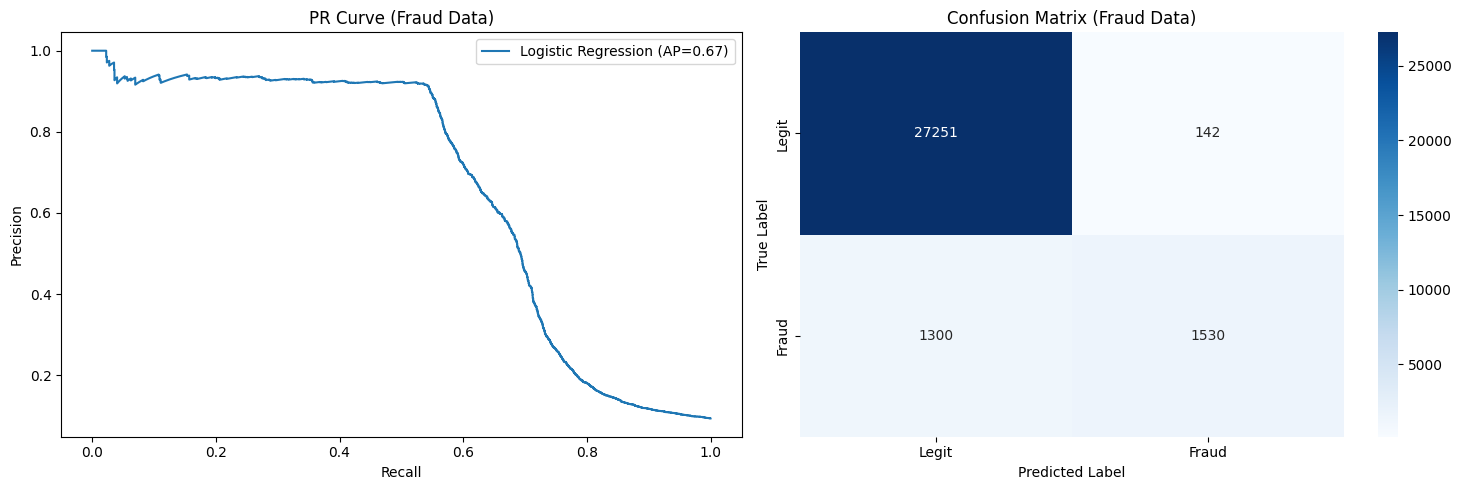


Test Set Classification Report (Logistic Regression - Fraud Data):
              precision    recall  f1-score   support

       Legit       0.95      0.99      0.97     27393
       Fraud       0.92      0.54      0.68      2830

    accuracy                           0.95     30223
   macro avg       0.93      0.77      0.83     30223
weighted avg       0.95      0.95      0.95     30223



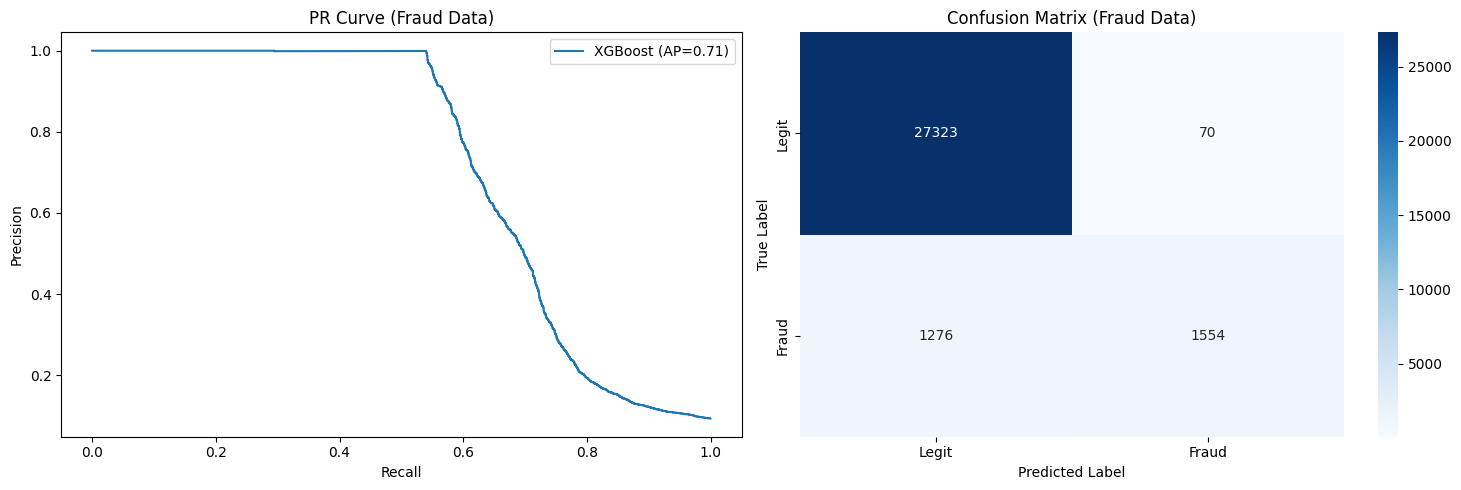


Test Set Classification Report (XGBoost - Fraud Data):
              precision    recall  f1-score   support

       Legit       0.96      1.00      0.98     27393
       Fraud       0.96      0.55      0.70      2830

    accuracy                           0.96     30223
   macro avg       0.96      0.77      0.84     30223
weighted avg       0.96      0.96      0.95     30223


Credit Card Data Results:


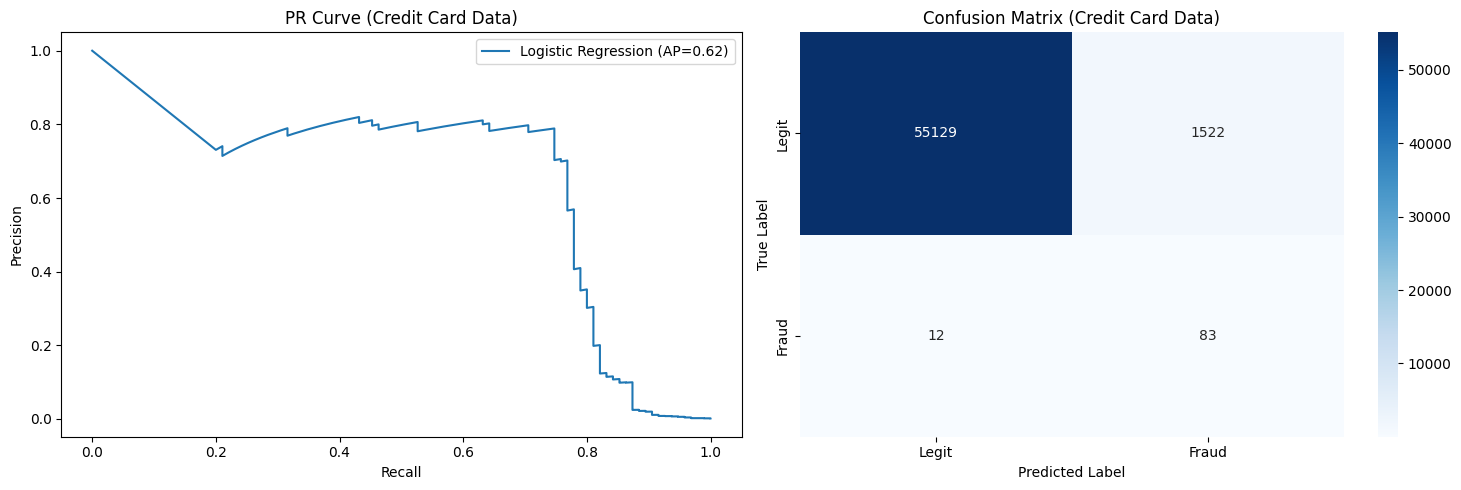


Test Set Classification Report (Logistic Regression - Credit Card Data):
              precision    recall  f1-score   support

       Legit       1.00      0.97      0.99     56651
       Fraud       0.05      0.87      0.10        95

    accuracy                           0.97     56746
   macro avg       0.53      0.92      0.54     56746
weighted avg       1.00      0.97      0.98     56746



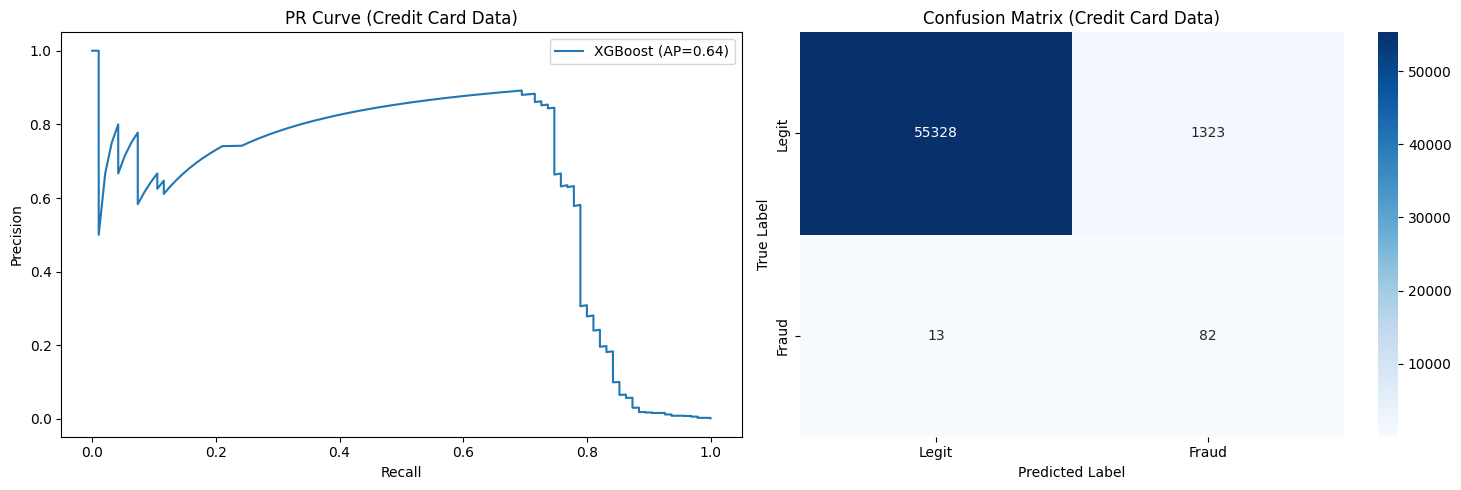


Test Set Classification Report (XGBoost - Credit Card Data):
              precision    recall  f1-score   support

       Legit       1.00      0.98      0.99     56651
       Fraud       0.06      0.86      0.11        95

    accuracy                           0.98     56746
   macro avg       0.53      0.92      0.55     56746
weighted avg       1.00      0.98      0.99     56746



In [16]:

# Final evaluations
print("\n" + "="*50)
print("FINAL TEST SET EVALUATION")
print("="*50)

print("\nFraud Data Results:")
lr_fraud_results = final_evaluation(lr_fraud, fraud_X_test, fraud_y_test,
                                  "Logistic Regression", "Fraud Data")
xgb_fraud_results = final_evaluation(xgb_fraud, fraud_X_test, fraud_y_test,
                                   "XGBoost", "Fraud Data")

print("\nCredit Card Data Results:")
lr_cc_results = final_evaluation(lr_cc, cc_X_test, cc_y_test,
                               "Logistic Regression", "Credit Card Data")
xgb_cc_results = final_evaluation(xgb_cc, cc_X_test, cc_y_test,
                                "XGBoost", "Credit Card Data")


In [ ]:

# 6. Save Best Models
dump(xgb_fraud, '../Data/processed/best_fraud_model.joblib')
dump(xgb_cc, '../Data/processed/best_cc_model.joblib')
print("\nBest models saved to disk")